# Kernel Density Estimation for gene expression data

In [18]:
# !pip install numpy scipy pandas matplotlib scikit-learn pyarrow

In [19]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

We're going to use [GSE2034](https://www.ncbi.nlm.nih.gov/geo/query/acc.cgi?acc=gse2034) ([Mendeley Data](https://data.mendeley.com/datasets/v3cc2p38hb/1), [Kaggle](https://www.kaggle.com/datasets/saurabhshahane/gene-expression-profiles-of-breast-cancer)) - a datsaset created for the article:
> Wang, Yixin, et al. *"Gene-expression profiles to predict distant metastasis of lymph-node-negative primary breast cancer."* The Lancet 365.9460 (2005): 671-679. [link](https://www.ihes.fr/~zinovyev/princmanif2006/Wang_lancet_2005.pdf)

The dataset is used for a task of predicting whether a distant metastasis will occur for a patient with breast cancer. It's an important task as metastasis is often a reason for additional costly treatment after tumor removal surgery.


The features in this dataset are [gene expressions](https://en.wikipedia.org/wiki/Gene_expression) of 12634 genes in sequential RNA. The stronger the gene expression is for a given gene, the more proteins are produced by this gene in the body.

The number of data features is much larger than the number of data elements therefore using probabilistic methods can be suspected to give really good results.

When working with medical data we often want to optimize recall as we want to minimize false negative predictions. Failing to detect illness is considered as a tragic failure as it can lead to death of the patient. As opposed to false positive outcomes that only result in additional medical checkups or potential side effects of unnecessary treatment.

In [20]:
df_norm = pd.read_csv("GSE2034-Normal.tsv", sep="\t")
df_tumor = pd.read_csv("GSE2034-Tumor.tsv", sep="\t")
df_norm = df_norm.drop(columns="Hybridization REF")
df_tumor = df_tumor.drop(columns="Hybridization REF")
df_norm = df_norm.transpose()
df_tumor = df_tumor.transpose()
df_norm["Tumor"] = 0
df_tumor["Tumor"] = 1

In [21]:
df = pd.concat([df_norm, df_tumor])
X = df.drop(columns="Tumor").to_numpy()
y = df["Tumor"].to_numpy()

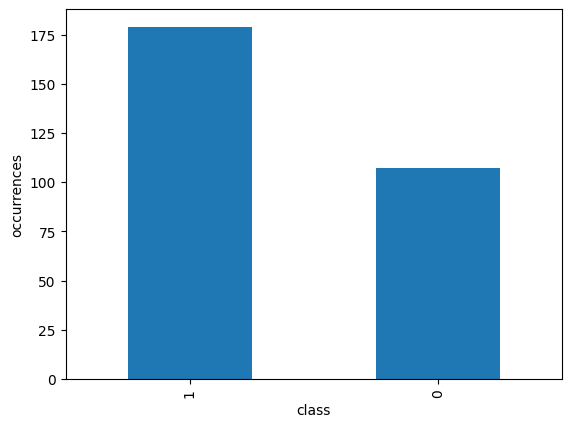

In [22]:
ax = (df["Tumor"].value_counts()).plot.bar()
plt.xlabel("class")
plt.ylabel("occurrences")
plt.show()

In [23]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import recall_score, f1_score, precision_score
from sklearn.naive_bayes import GaussianNB

X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.33,
    random_state=0,
    stratify=y,
)

clf_nb_gaussian = GaussianNB()
clf_nb_gaussian.fit(X_train, y_train)

y_pred = clf_nb_gaussian.predict(X_test)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

print(f"Precision: {100 * precision:.2f}%")
print(f"Recall   : {100 * recall:.2f}%")
print(f"F1-score : {100 * f1:.2f}%")

Precision: 73.08%
Recall   : 64.41%
F1-score : 68.47%


This score is not that great. We must remember that Naive Bayes for continuous data assumes that it comes from normal distribution. Is that the case for our dataset? 

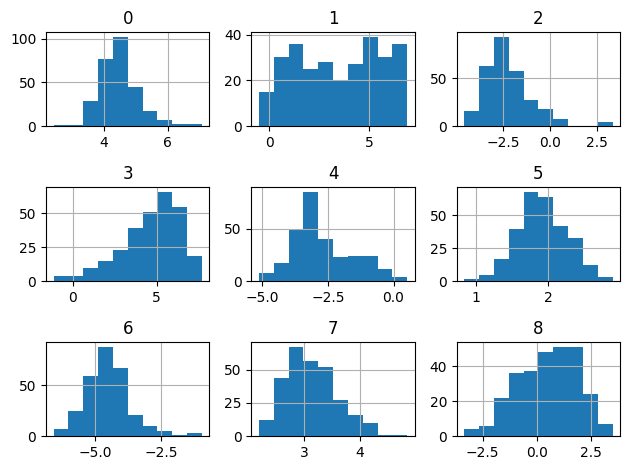

In [24]:
pd.DataFrame(X[:, :9]).hist()
plt.tight_layout()
plt.show()

Some of the distributions resemble normal distribution however it's safe to assume we might get better result using Kernel Density Estimation


There is no KDE Naive Bayes in scikit-learn, so we're going to implement it using the [instruction](https://scikit-learn.org/stable/developers/develop.html)

1. Our class will inherit from `BaseEstimator`, `ClassifierMixin`
2. All hyperparameters must be passed to the constructor and then assigned to a member of the same name
3. We must implement `.fit(X, y)` and `.predict(X)` method. Additionally `.predict_proba(X)` for some classifiers
4. At the beginning of `.fit(X, y)` we perform the `check_X_y()` check to validate the input. At the beginning of `.predict(X)` we perform a similar `check_array()` check.

This way we'll be able to use `GridSearchCV` with our model

In [25]:
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.neighbors import KernelDensity
from sklearn.utils import check_array, check_X_y


class KernelDensityEstimationNB(BaseEstimator, ClassifierMixin):
    """
    Naive Bayes with KDE estimation of feature distributions.

    Parameters
    ----------
    kernel : str
        Kernel name, passed to KernelDensity

    bandwidth : float
        Kernel bandwidth
    """

    def __init__(self, kernel: str = "gaussian", bandwidth: float = 1.0):
        self.kernel = kernel
        self.bandwidth = bandwidth

    def fit(self, X, y):
        X = np.array(X)
        y = np.array(y)
        X, y = check_X_y(X, y)
        assert y.min() == 0
        assert y.max() == len(np.unique(y)) - 1

        # vector of possible classes
        self.classes_ = np.unique(y)

        # vector for class priors - proportion of classes in the training set
        self.log_priors_ = np.empty(len(self.classes_))

        # list of KernelDensity models, one for each class
        self.kde_models_ = []

        for class_idx in self.classes_:
            X_current = X[y == class_idx]
            self.log_priors_[class_idx] = np.log(X_current.shape[0] / X.shape[0])
            kde = KernelDensity(kernel=self.kernel, bandwidth=self.bandwidth)
            kde.fit(X_current)
            self.kde_models_.append(kde)

        return self

    def predict(self, X):
        # make sure that we are working on Numpy array, and perform basic
        # sanity checks
        X = np.array(X)
        X = check_array(X)

        # use KDE models and calculate log-likelihoods for each sample
        log_likelihoods = np.array(
            [kde.score_samples(X) for kde in self.kde_models_]
        ).transpose()

        # calculate posterior probability: log-prior + log-likelihood
        posteriors = np.array(log_likelihoods + self.log_priors_)

        # select the index of class with maximum a posteriori (MAP) rule
        map_class = self.classes_[posteriors.argmax(axis=1)]

        return map_class

In [26]:
clf_nb_kde = KernelDensityEstimationNB()
clf_nb_kde.fit(X_train, y_train)

y_pred = clf_nb_kde.predict(X_test)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

print(f"Precision: {100 * precision:.2f}%")
print(f"Recall   : {100 * recall:.2f}%")
print(f"F1-score : {100 * f1:.2f}%")

Precision: 60.98%
Recall   : 84.75%
F1-score : 70.92%


We have much better recall than before but precision score became worse. That shouldn't be alarming as we want to improve recall but it would be nice to keep precision and reasonable level

We can use Silverman's rule of thumb - a simple formula for the kernel bandwidth for unimodal distribution ([Wikipedia](https://en.wikipedia.org/wiki/Multivariate_kernel_density_estimation#Rule_of_thumb)):

In [27]:
clf_nb_kde = KernelDensityEstimationNB(bandwidth="silverman")
clf_nb_kde.fit(X_train, y_train)

y_pred = clf_nb_kde.predict(X_test)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

print(f"Precision: {100 * precision:.2f}%")
print(f"Recall   : {100 * recall:.2f}%")
print(f"F1-score : {100 * f1:.2f}%")

class_0_bandwidth = clf_nb_kde.kde_models_[0].bandwidth_
class_1_bandwidth = clf_nb_kde.kde_models_[1].bandwidth_

print(f"Class bandwidths: {class_0_bandwidth:.4f}, {class_1_bandwidth:.4f}")

Precision: 62.20%
Recall   : 86.44%
F1-score : 72.34%
Class bandwidths: 0.9990, 0.9990


We could improve the precision using hyperparameter tuning, as `bandwidth` is a very impactful hyperparameter

Let's tune the `bandwidth`

In [28]:
from sklearn.model_selection import GridSearchCV

clf_nb_kde = KernelDensityEstimationNB()

param_grid = {"bandwidth": np.linspace(0.75, 1.25, 100)}

cv = GridSearchCV(
    estimator=clf_nb_kde, param_grid=param_grid, scoring="f1", cv=5, n_jobs=-1
)

cv.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=KernelDensityEstimationNB(), n_jobs=-1,
             param_grid={'bandwidth': array([0.75      , 0.75505051, 0.76010101, 0.76515152, 0.77020202,
       0.77525253, 0.78030303, 0.78535354, 0.79040404, 0.79545455,
       0.80050505, 0.80555556, 0.81060606, 0.81565657, 0.82070707,
       0.82575758, 0.83080808, 0.83585859, 0.84090909, 0.8459596 ,
       0.8510101 , 0.85606061, 0.86111111, 0.866161...
       1.07828283, 1.08333333, 1.08838384, 1.09343434, 1.09848485,
       1.10353535, 1.10858586, 1.11363636, 1.11868687, 1.12373737,
       1.12878788, 1.13383838, 1.13888889, 1.14393939, 1.1489899 ,
       1.1540404 , 1.15909091, 1.16414141, 1.16919192, 1.17424242,
       1.17929293, 1.18434343, 1.18939394, 1.19444444, 1.19949495,
       1.20454545, 1.20959596, 1.21464646, 1.21969697, 1.22474747,
       1.22979798, 1.23484848, 1.23989899, 1.24494949, 1.25      ])},
             scoring='f1')

In [29]:
cv.best_params_

{'bandwidth': 1.2045454545454546}

In [30]:
y_pred = cv.predict(X_test)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

print(f"Precision: {100 * precision:.2f}%")
print(f"Recall   : {100 * recall:.2f}%")
print(f"F1-score : {100 * f1:.2f}%")

Precision: 65.06%
Recall   : 91.53%
F1-score : 76.06%


That's a good score. We improved the recall significantly and precision score is better. We also got the highest recall score so the training can be considered successful